In [25]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy import sparse
from sklearn.cluster import KMeans

%matplotlib inline

### Main algorithm

In [293]:
# 'V_Sigma_V_x' & 'c_Ssq_E_Ssq_x' & 'c_x' are used in a custom matVec product (in a LinearOperator)
def V_Sigma_V_x(V_T, Sigma_diag, x, s, use_normalized_L): # V^T * Sigma * V * vec_x
    if use_normalized_L:
        Sigma_diag = 2.0 - Sigma_diag
    else:
        Sigma_diag = s - Sigma_diag
    return V_T.dot( np.multiply(Sigma_diag, (V_T.T).dot(x) ) )
def c_Ssq_E_Ssq_x(s, n, x, use_normalized_L, S_sqrt = None): # c(s,n) * S_squared * eye * S_squared * vec_x
    if use_normalized_L:
        return 2.0/s * S_sqrt * np.repeat((S_sqrt * x).sum(), len(x))
    return np.repeat(s/n * x.sum(), len(x))
def c_x(s, x, use_normalized_L):
    if use_normalized_L:
        return 2.0 * x
    else:
        return s * x

## input:
#      W - matrix of weights
#      L = S - W - Laplacian matrix
#      s = W.sum() - sum of weights
#      cnt_V = W.shape[0] - number of vertices
#      evals, evecs - already found eigenpairs. evecs are transposed
## output
#      evals, evecs - expanded eigenpairs
def Incremental_IO_step(W, L, s, use_normalized_L, S_sqrt, cnt_V, evals, evecs):
    L_perturbed = sparse.linalg.LinearOperator(W.shape, matvec=lambda x, W=W, V=evecs, evals=evals, s=s, n=cnt_V,
                                               is_norm=use_normalized_L, S_sqrt=S_sqrt
                                               : L.dot(x) + V_Sigma_V_x(V, evals, x, s, is_norm) 
                                               + c_Ssq_E_Ssq_x(s, n, x, is_norm, S_sqrt) 
                                               - c_x(s, x ,is_norm))
    lead_eval, lead_evec = sparse.linalg.eigsh(L_perturbed, k=1, which='LM') # Why is LM?
    if use_normalized_L:
        evals = np.concatenate((evals, lead_eval + 2.0))
    else:
        evals = np.concatenate((evals, lead_eval + s))
    evecs = np.concatenate((evecs, lead_evec), axis=1)
    return evals, evecs

## input:
#      W - matrix of weights. if all vertices weight 1, it's an adjacency matrix
#      K - maximum number of clusters & eigenpairs
#      rule_of_stop - function that measure quality of a partition.
#          first three arguments should wait for: communities, L, evals
#      args_of_rule_of_stop - other arguments of a custom stopping function
## output:
#      partition: list of vertices' communities IDs 
#      L - Laplacian matrix
#      evals - computed eigenvalues
#      evecs - computed eigenvectors
def Spectral_Clusterization_IO(W, K, use_normalized_L = False, rule_of_stop = None, *args_of_rule_of_stop):
    W = W.astype(np.float64, copy = True)
    # normalize W    
    inv_S_sqrt = np.ravel(1.0/np.sqrt(W.sum(0)))
    W = W.multiply(inv_S_sqrt).multiply(inv_S_sqrt.reshape(len(inv_S_sqrt), 1))
    
    # compute the Laplasian matrix
    L = sparse.diags(np.ravel(W.sum(0))).tocsr() - W
    S_sqrt = None # used only in the normalized case
    if use_normalized_L:
        S_sqrt = np.ravel(np.sqrt(W.sum(0)))
        inv_S_sqrt = np.ravel(1.0/np.sqrt(W.sum(0)))
        L = L.multiply(inv_S_sqrt).multiply(inv_S_sqrt.reshape(len(inv_S_sqrt), 1))        
    
    cnt_V = W.shape[0]
    evals = np.array([0.0])
    evecs = np.array([np.zeros(cnt_V, dtype = np.float64)]).T
    current_cluster_cnt, s, kmeans_partition, communities = 1, W.sum(), [], []
    
    while current_cluster_cnt <= K and (rule_of_stop is None or rule_of_stop(communities, L, evals, *args_of_rule_of_stop) == False):
        evals, evecs = Incremental_IO_step(W, L, s, use_normalized_L, S_sqrt, cnt_V, evals, evecs)
        current_cluster_cnt += 1
        kmeans_partition = KMeans(n_clusters = current_cluster_cnt, random_state=0).fit(evecs).labels_
        # create input of a quality function (communities - further rule_of_stop argument)
        communities = {i:set() for i in range(current_cluster_cnt)}
        for idx, cluster_num in enumerate(kmeans_partition):
            communities[cluster_num].add(idx)
        communities = list(communities.values())
    
    return kmeans_partition, L, evals, evecs.T

### Clustering metrics for user-guided spectral clustering

In [27]:
# EXAMPLE of a stopping function: MODULARITY
## input:
#      threshold - suitable modularity
## output
#     return False = partition isn't suitable
def modularity(communities, L, evals, G, threshold):
    if communities == []:
        return False
    # print("modularity of the partition =", nx.algorithms.community.quality.modularity(G, clusters))
    if nx.algorithms.community.quality.modularity(G, communities) > threshold:
        return True
    return False

# EXAMPLE of a stopping function: SCALED MEDIAN CLUSTER SIZE
## input:
#      threshold - suitable scaled median cluster size
## output
#     return False = partition isn't suitable
def scaled_median_cluster_size(communities, L, evals, threshold):
    if communities == []:
        return False
    sizes = []
    for comm in communities:
        sizes.append(len(comm))
    #print("SMCS of the partition =", np.median(np.array(sizes)) / sum(sizes))
    if np.median(np.array(sizes)) / sum(sizes) < threshold:
        return True
    return False

# EXAMPLE of a stopping function: SCALED MAXIMUM CLUSTER SIZE
## input:
#      threshold - suitable scaled maximum cluster size
## output
#     return False = partition isn't suitable
def scaled_maximum_cluster_size(communities, L, evals, threshold):
    if communities == []:
        return False
    sizes = []
    for comm in communities:
        sizes.append(len(comm))
    #print("SMCS of the partition =", max(sizes) / sum(sizes))
    if max(sizes) / sum(sizes) < threshold:
        return True
    return False

# EXAMPLE of a stopping function: SCALED SPECTRUM ENERGY
## input:
#      threshold - suitable scaled spectrum energy
## output
#     return False = partition isn't suitable
def scaled_spectrum_energy(communities, L, evals, threshold):
    if communities == []:
        return False
    #print(sum(evals) / sum(L.diagonal()))
    if sum(evals) / sum(L.diagonal()) > threshold:
        return True
    return False

### Examples

#### Initial graph

Number of vertices = 34
Number of edges = 78


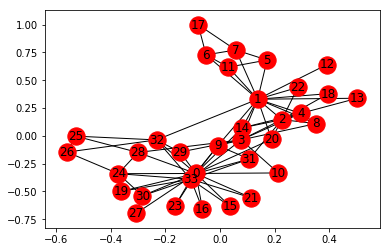

In [28]:
# from the lecture 10
kn = nx.read_gml('karate.gml')
cnt_V = kn.number_of_nodes()
print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))
nx.draw_networkx(kn) #Draw the graph

adj_matrix = nx.adjacency_matrix(kn) # in CSR format
adj_matrix = adj_matrix.astype(np.float64, copy = True)

## Unnormalized Laplacian Matrix

#### Residuals of 10 smallest eigenpairs (count from the second one)

In [266]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 10, False)
for i in range(1, len(evals)):
    print("Residual", i, ":", np.linalg.norm(L.dot(evecs[i]) - evals[i]*evecs[i]))

Residual 1 : 3.26557197381e-14
Residual 2 : 1.29763397322e-14
Residual 3 : 5.98099251161e-14
Residual 4 : 5.05205108252e-14
Residual 5 : 4.95417387689e-14
Residual 6 : 3.80776131839e-14
Residual 7 : 4.34297459286e-14
Residual 8 : 2.61912193815e-14
Residual 9 : 4.49507744719e-14
Residual 10 : 3.52477658537e-14


#### Partition with modularity settings

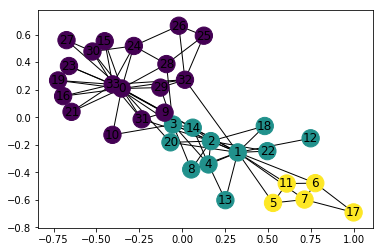

In [297]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 6, 
                                                               False, modularity, kn, 0.37)
nx.draw_networkx(kn, node_color=kmeans_partition)

#### Partition with suitable scaled median cluster size

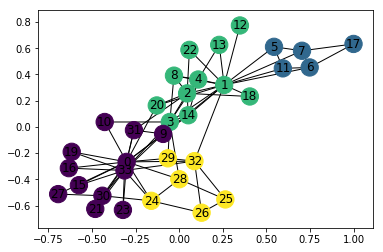

In [188]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 6, 
                                                               False, scaled_median_cluster_size, 0.3)
nx.draw_networkx(kn, node_color=kmeans_partition)

#### Partition with suitable scaled maximum cluster size

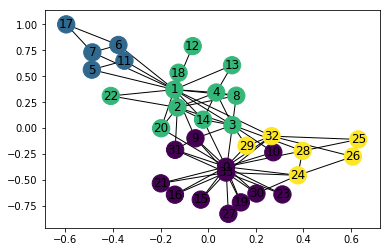

In [189]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 6, 
                                                               False, scaled_maximum_cluster_size, 0.4)
nx.draw_networkx(kn, node_color=kmeans_partition)

#### Partition with suitable scaled spectrum energy

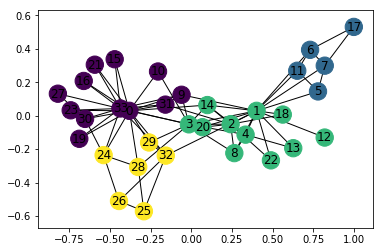

In [190]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 6, 
                                                               False, scaled_spectrum_energy, 0.01)
nx.draw_networkx(kn, node_color=kmeans_partition)

## Normalized Laplacian Matrix
##### the same experiments 

#### Residuals of 10 smallest eigenpairs (count from the second one)

In [296]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 10, True)
for i in range(1, len(evals)):
    print("Residual", i, ":", np.linalg.norm(L.dot(evecs[i]) - evals[i]*evecs[i]))

Residual 1 : 1.94166845411e-15
Residual 2 : 1.70556513324e-15
Residual 3 : 1.60055810515e-15
Residual 4 : 1.78671960108e-15
Residual 5 : 8.84135222496e-16
Residual 6 : 1.20980391286e-15
Residual 7 : 9.48857666671e-16
Residual 8 : 7.06315835472e-16
Residual 9 : 7.41741874958e-16
Residual 10 : 1.18492980716e-15


#### Partition with modularity settings

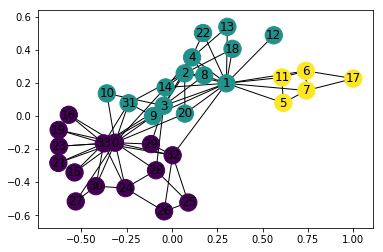

In [298]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 6, 
                                                               True, modularity, kn, 0.37)
nx.draw_networkx(kn, node_color=kmeans_partition)

#### Partition with suitable scaled median cluster size

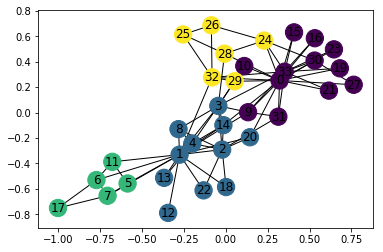

In [302]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 6, 
                                                               True, scaled_median_cluster_size, 0.3)
nx.draw_networkx(kn, node_color=kmeans_partition)

#### Partition with suitable scaled maximum cluster size

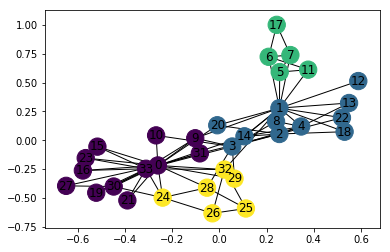

In [303]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 6, 
                                                               True, scaled_maximum_cluster_size, 0.4)
nx.draw_networkx(kn, node_color=kmeans_partition)

#### Partition with suitable scaled spectrum energy

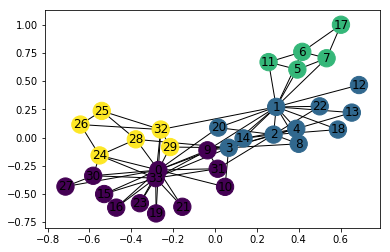

In [310]:
kmeans_partition, L, evals, evecs = Spectral_Clusterization_IO(adj_matrix, 6, 
                                                               True, scaled_spectrum_energy, 0.01)
nx.draw_networkx(kn, node_color=kmeans_partition)